In [1]:
import os

os.chdir("..")

In [2]:
from datasets.load_data.gluonts_dataset import GluontsDataset
from utilsforecast.plotting import plot_series
import pandas as pd
from models.NBeatsStackMoe import NBeatsStackMoe
from models.NBeatsMoeLags import NBeatsMoeLags
from neuralforecast import NeuralForecast
from utils import load_dataset, train_test_split
from models.callbacks.probs_collector import GateValuesCollectorCallback
from neuralforecast.losses.numpy import smape
from neuralforecast.models import NBEATS


m1, horizon, n_lags, freq_str, freq_int = GluontsDataset.load_everything("m1_monthly")

m1['y'] = m1['y'].astype(float)

c:\Users\ricar\mixture_of_experts_time_series\venv\Lib\site-packages\gluonts\json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
c:\Users\ricar\mixture_of_experts_time_series\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-23 15:29:56,748	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-05-23 15:29:56,982	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
INFO:root:using dataset already processed in path C:\Users\ricar\.gluonts\datasets\m1_monthly.


In [3]:
horizon = horizon
input_size = n_lags

        data          trend       seasonal      remainder
0   697458.0  878476.705748 -335228.658033  154209.952285
1  1187650.0  874973.804619  307545.369156    5130.826226
2  1069690.0  872259.959808  339814.510940 -142384.470747
3  1078430.0  870284.584877   29748.418659  178396.996463
4  1059910.0  869052.699871  176808.371308   14048.928821


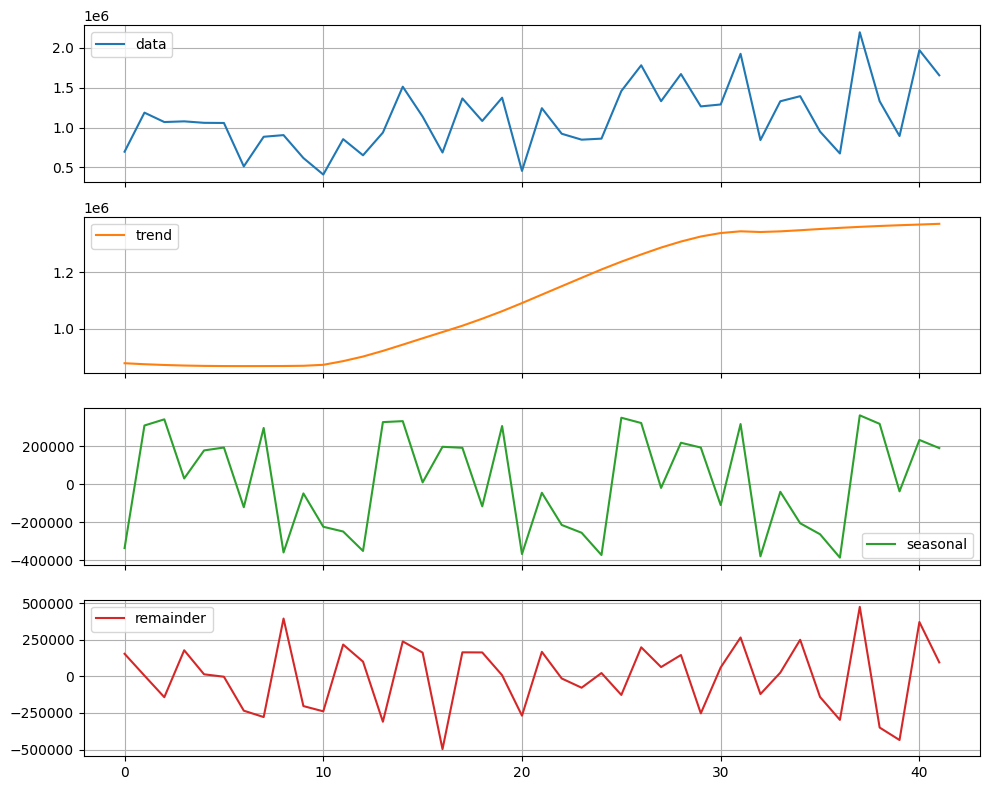

In [4]:
# decompose the time series
from statsforecast.models import MSTL
from statsforecast import StatsForecast
import matplotlib.pyplot as plt

sf =  StatsForecast(models=[MSTL(season_length=[12] )], freq="M")
sf.fit(m1)

decomposition = sf.fitted_[0, 0].model_
print(decomposition.head())

# Plot the decomposed components: observed, trend, seasonal, and remainder.
decomposition.plot(subplots=True, grid=True, figsize=(10, 8))
plt.tight_layout()
plt.show()

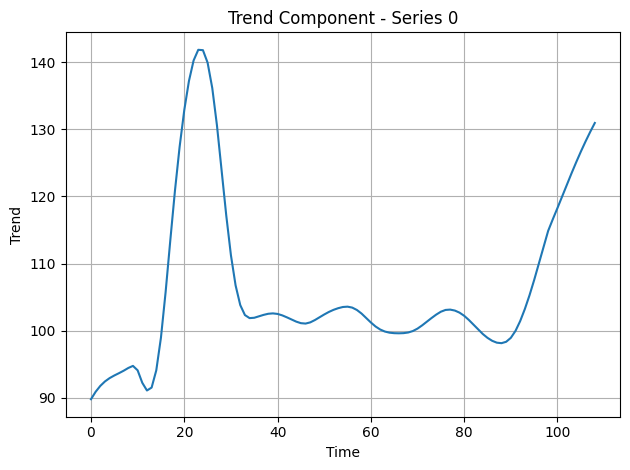

In [5]:
# Create datasets from decomposed components
trend = pd.DataFrame([sf.fitted_[i, 0].model_['trend'].values for i in range(len(sf.fitted_))])
seasonal = pd.DataFrame([sf.fitted_[i, 0].model_['seasonal'].values for i in range(len(sf.fitted_))])
remainder = pd.DataFrame([sf.fitted_[i, 0].model_['remainder'].values for i in range(len(sf.fitted_))])

# Plot the trend of the first series
plt.plot(trend.iloc[1])
plt.title("Trend Component - Series 0")
plt.xlabel("Time")
plt.ylabel("Trend")
plt.grid(True)
plt.tight_layout()
plt.show()


In [6]:
def convert_to_nixtla_format(df, component_name="trend", time_index=None):
    long_df = df.copy()
    long_df["unique_id"] = [f"series_{i}" for i in range(len(df))]
    long_df = long_df.melt(id_vars=["unique_id"], var_name="time_idx", value_name="y")


    long_df["ds"] = long_df["time_idx"].astype(int)

    long_df = long_df[["unique_id", "ds", "y"]]

    #remove nan
    long_df = long_df.dropna()
    
    return long_df

trend_ds = convert_to_nixtla_format(trend, "trend")
seasonal_ds = convert_to_nixtla_format(seasonal, "seasonal")
remainder_ds = convert_to_nixtla_format(remainder, "remainder")


In [7]:
# create test and train datasets

Y_train_trend, Y_test_trend = train_test_split(trend_ds, horizon)
Y_train_seasonal, Y_test_seasonal = train_test_split(seasonal_ds, horizon)
Y_train_remainder, Y_test_remainder = train_test_split(remainder_ds, horizon)

Y_train_trend

,unique_id,ds,y
0,series_0,0,878476.705748
1,series_0,1,874973.804619
2,series_0,2,872259.959808
3,series_0,3,870284.584877
4,series_0,4,869052.699871
...,...,...,...
39951,series_99,43,11237.691663
39952,series_99,44,11367.636027
39953,series_99,45,11443.859596
39954,series_99,46,11372.063772


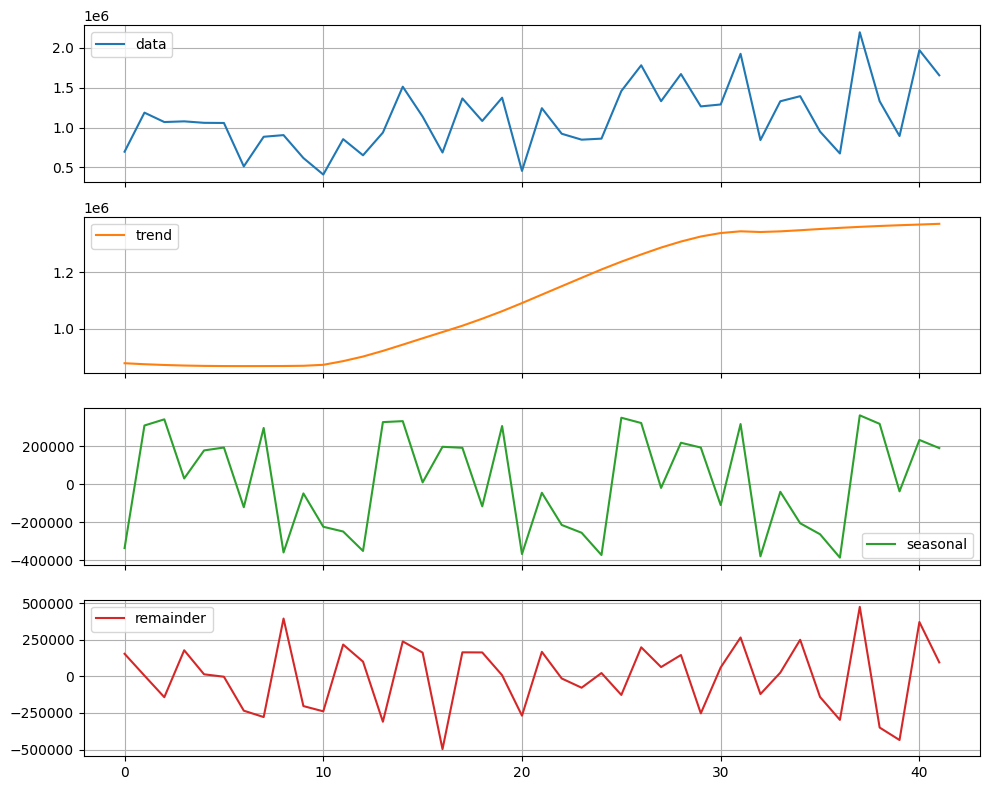

In [8]:
sf.fitted_[0, 0].model_.plot(subplots=True, grid=True, figsize=(10, 8))
plt.tight_layout()
plt.show()

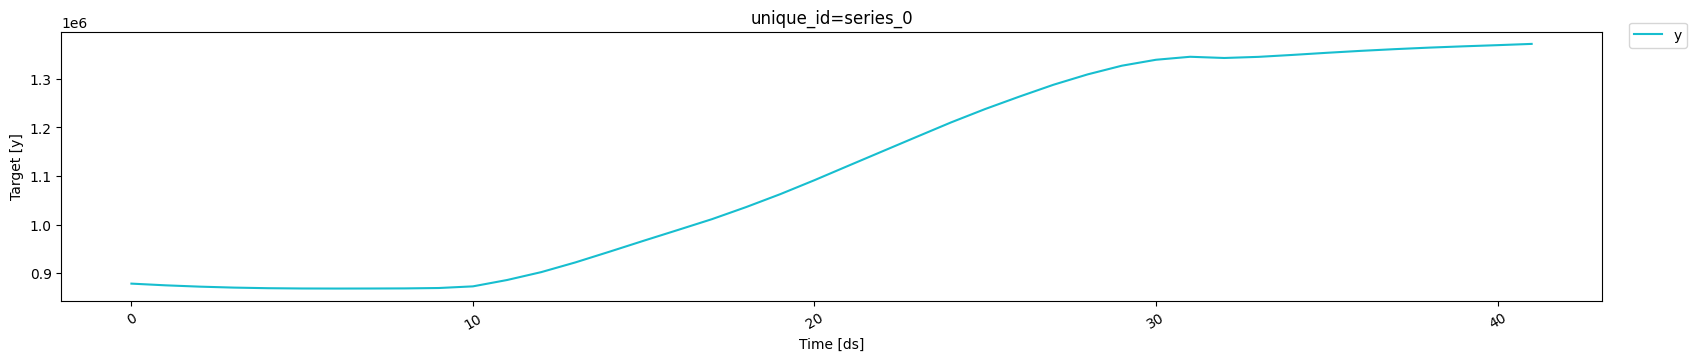

In [9]:
# plot series_0 from trend~
plot_series(Y_train_trend, Y_test_trend, ids=['series_0'])



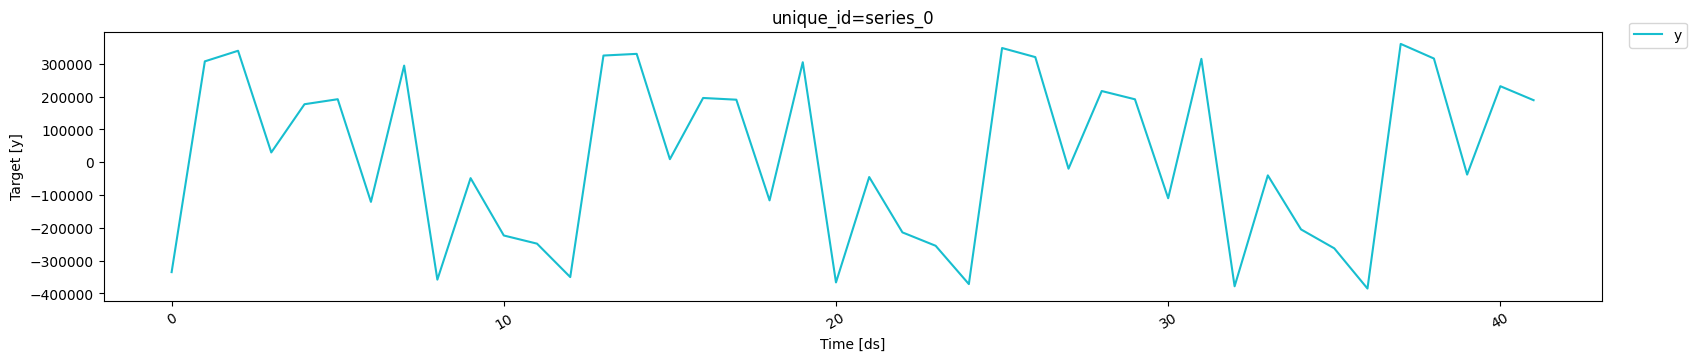

In [10]:
plot_series(Y_train_seasonal, Y_test_seasonal, ids=['series_0'])

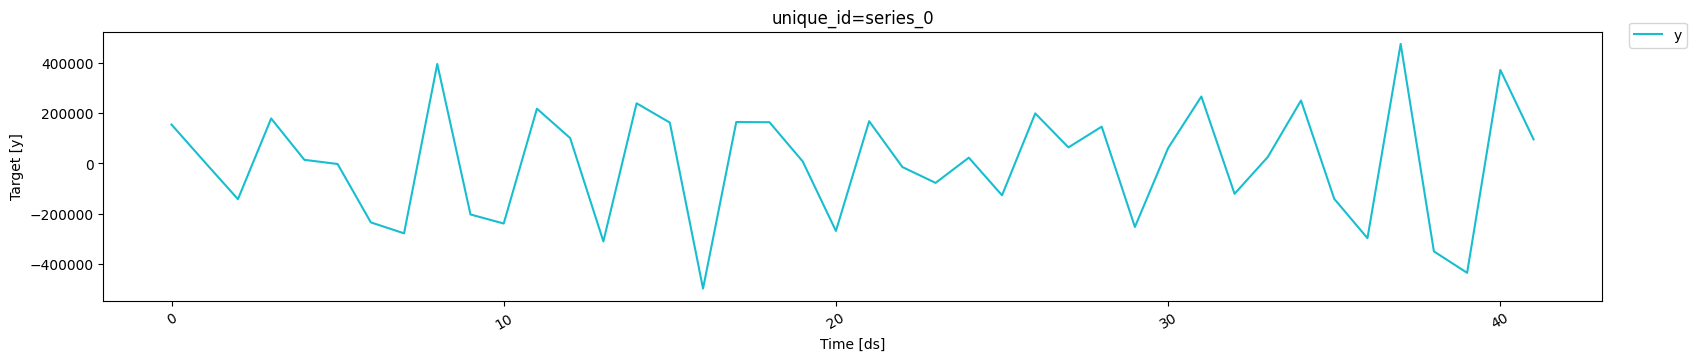

In [11]:
plot_series(Y_train_remainder, Y_test_remainder, ids=['series_0'])

In [12]:
def calculate_smape(Y_test_df, Y_hat_df, forecast_col):
    """Calculate the sMAPE."""
    y_true = Y_test_df['y'].values
    try:
        y_hat = Y_hat_df[forecast_col].values
    except KeyError as exc:
        raise KeyError(
            f"Forecast column '{forecast_col}' not found in predictions!") from exc
   
    n_series = Y_test_df['unique_id'].nunique()
    try:
        y_true = y_true.reshape(n_series, -1)
        y_hat = y_hat.reshape(n_series, -1)
    except Exception as e:
        raise ValueError("Error reshaping arrays") from e

    return smape(y_true, y_hat)

First lets train on the m1 ...

In [13]:
m1['ds'] = m1.groupby('unique_id').cumcount()

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 616 K  | train
4 | gate         | Sequential    | 63     | train
-------------------------------------------------------
616 K     Trainable params
340       Non-trainable params
616 K     Total params
2.466     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 20/20 [00:00<00:00, 29.49it/s, v_num=20, train_loss_step=95.50, train_loss_epoch=984.0, valid_loss=1.84e+3]    

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 49: 100%|██████████| 20/20 [00:00<00:00, 29.36it/s, v_num=20, train_loss_step=95.50, train_loss_epoch=984.0, valid_loss=1.84e+3]


Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 20/20 [00:00<00:00, 156.21it/s]
all_gates_cat shape: torch.Size([617, 3])

mean inputs_cat:  tensor([0.3702, 0.2817, 0.3481], device='cuda:0')

num_experts: tensor([123,  54,  96], device='cuda:0')

Best expert counts: tensor([247, 151, 219], device='cuda:0')


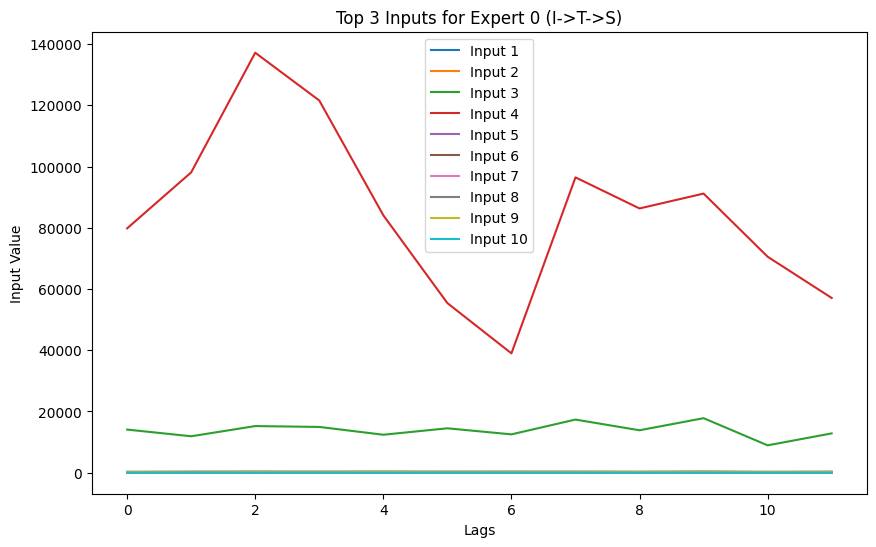

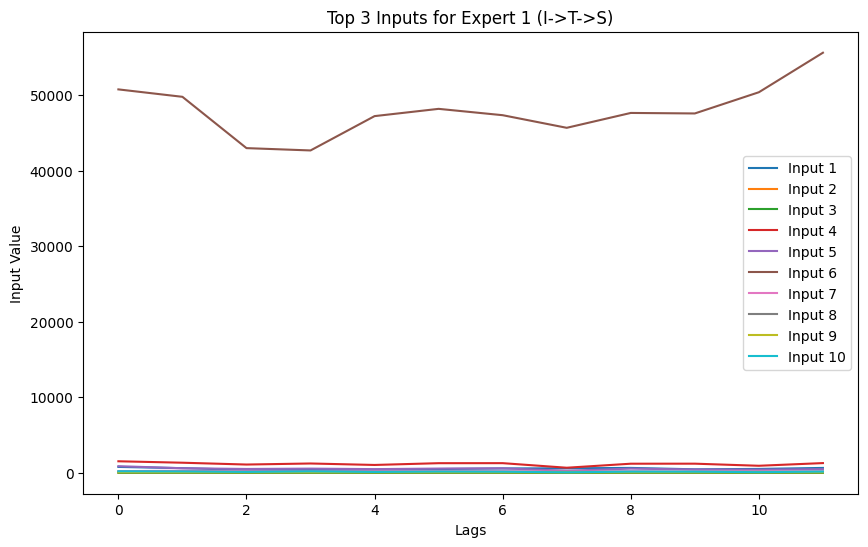

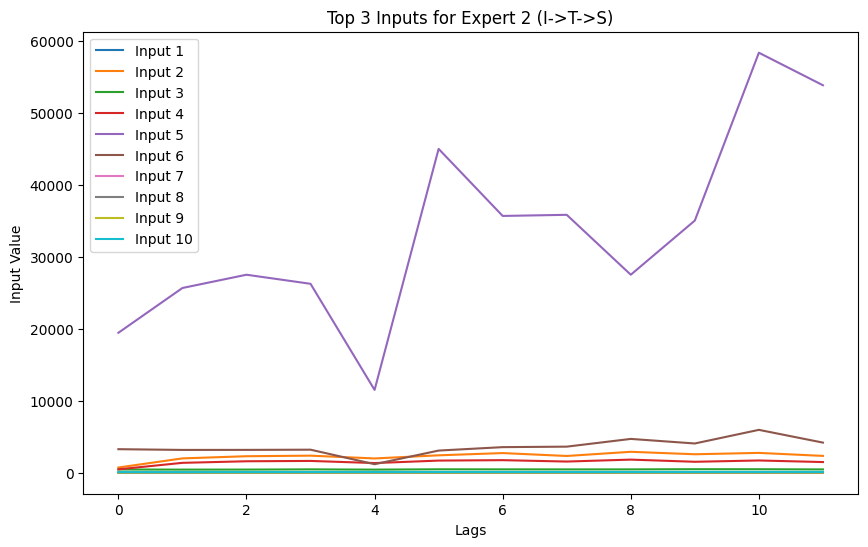

Resetting gate values for next epoch.
Predicting DataLoader 0: 100%|██████████| 20/20 [00:00<00:00, 23.00it/s] 
sMAPE for original: 0.14180642618266737


In [14]:
y_train, y_test = train_test_split(m1, horizon)

prob_collector = GateValuesCollectorCallback(is_stack=True, reset_on_epoch=True)
nf = NeuralForecast(
    models=[
        NBeatsStackMoe(
            input_size=input_size, 
            h=horizon,
            mlp_units = 3 * [[256, 256]],
            callbacks=[prob_collector],
            # n_blocks = [3, 3, 3],
        )
    ], 
    freq=1
)
nf.fit(df=y_train, static_df=None, val_size=horizon)
predictions = nf.predict(futr_df=y_test)

smape_original = calculate_smape(y_test, predictions, 'NBeatsStackMoe')
print(f'sMAPE for original: {smape_original}')

Now lets test on the trend test and train ... 

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 20/20 [00:00<00:00, 130.97it/s]
all_gates_cat shape: torch.Size([617, 3])

mean inputs_cat:  tensor([0.3446, 0.2758, 0.3797], device='cuda:0')

num_experts: tensor([ 65,  38, 285], device='cuda:0')

Best expert counts: tensor([164,  91, 362], device='cuda:0')


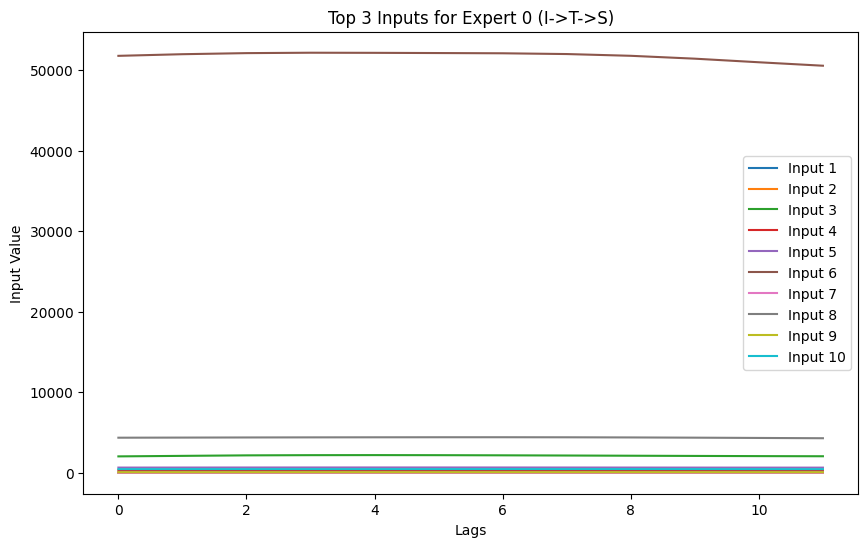

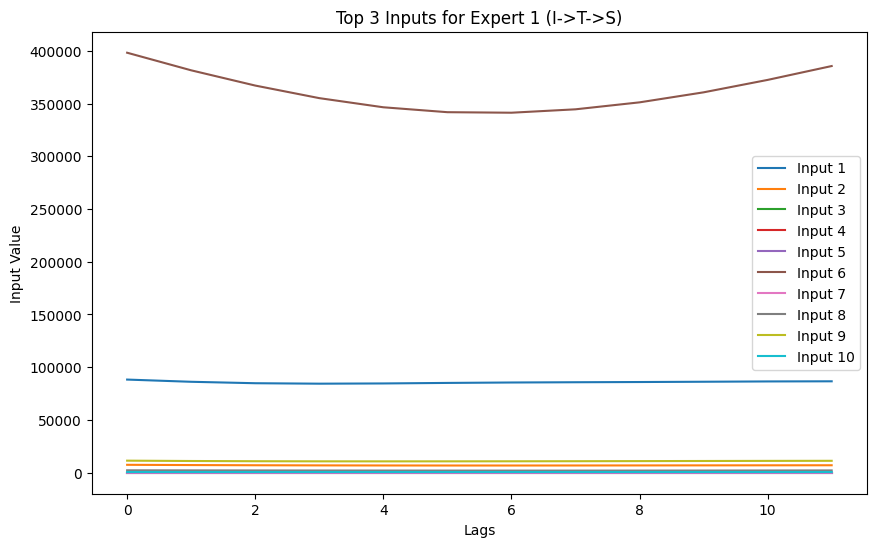

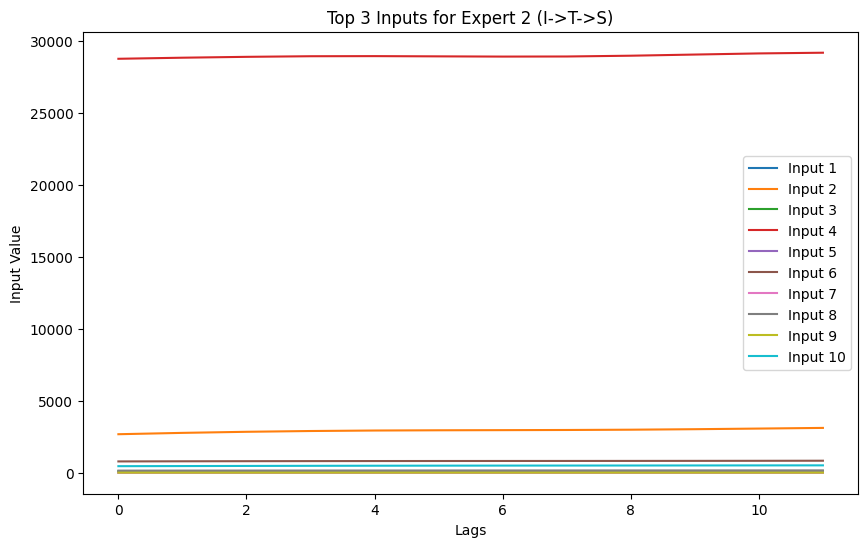

Resetting gate values for next epoch.
Predicting DataLoader 0: 100%|██████████| 20/20 [00:00<00:00, 26.08it/s] 

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 20/20 [00:00<00:00, 142.78it/s]
all_gates_cat shape: torch.Size([617, 3])

mean inputs_cat:  tensor([0.3245, 0.2792, 0.3963], device='cuda:0')

num_experts: tensor([ 56,  69, 307], device='cuda:0')

Best expert counts: tensor([102, 127, 388], device='cuda:0')


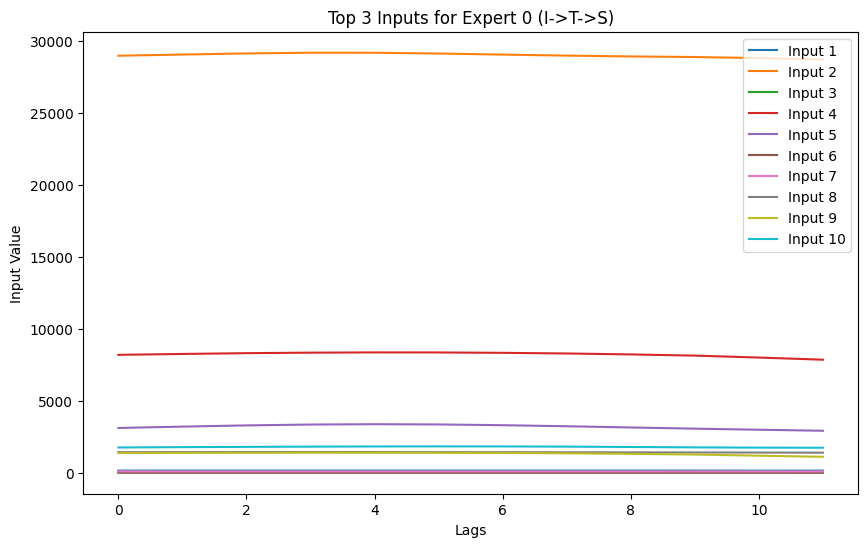

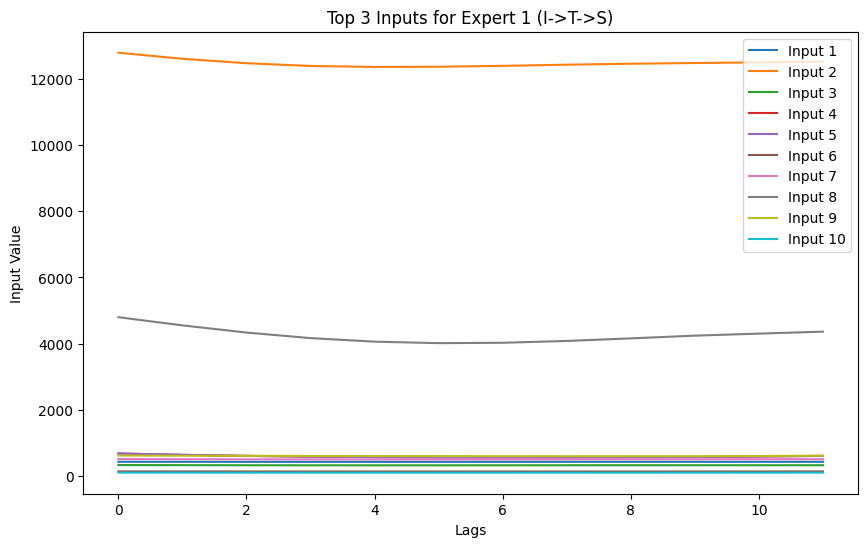

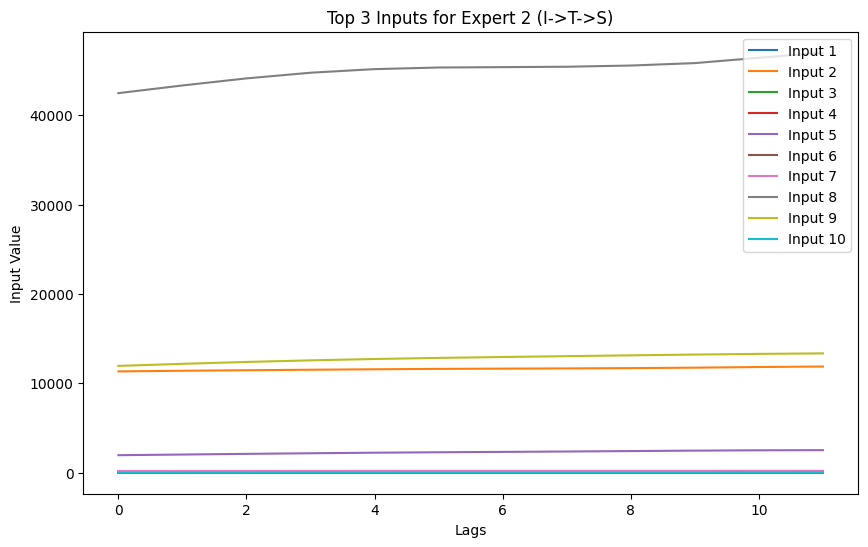

Resetting gate values for next epoch.
Predicting DataLoader 0: 100%|██████████| 20/20 [00:00<00:00, 26.89it/s] 

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 20/20 [00:00<00:00, 128.72it/s]
all_gates_cat shape: torch.Size([617, 3])

mean inputs_cat:  tensor([0.3505, 0.2573, 0.3922], device='cuda:0')

num_experts: tensor([ 97,  26, 283], device='cuda:0')

Best expert counts: tensor([171,  62, 384], device='cuda:0')


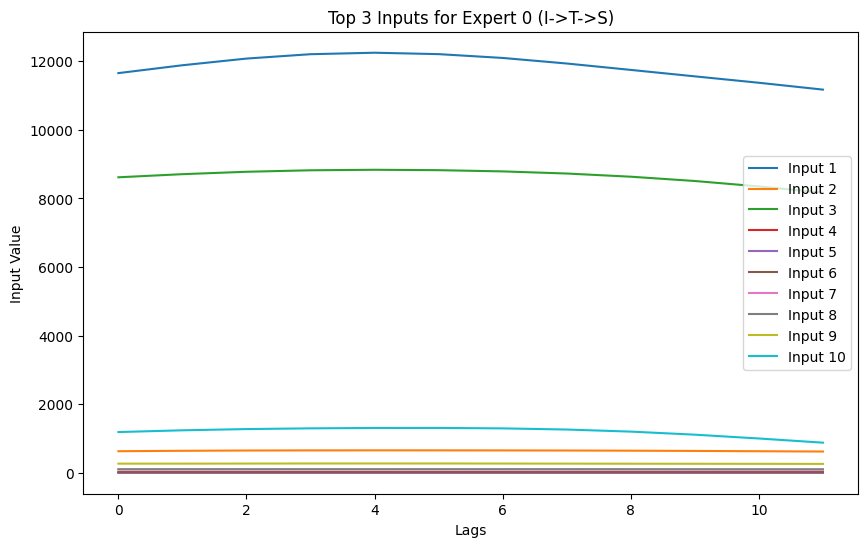

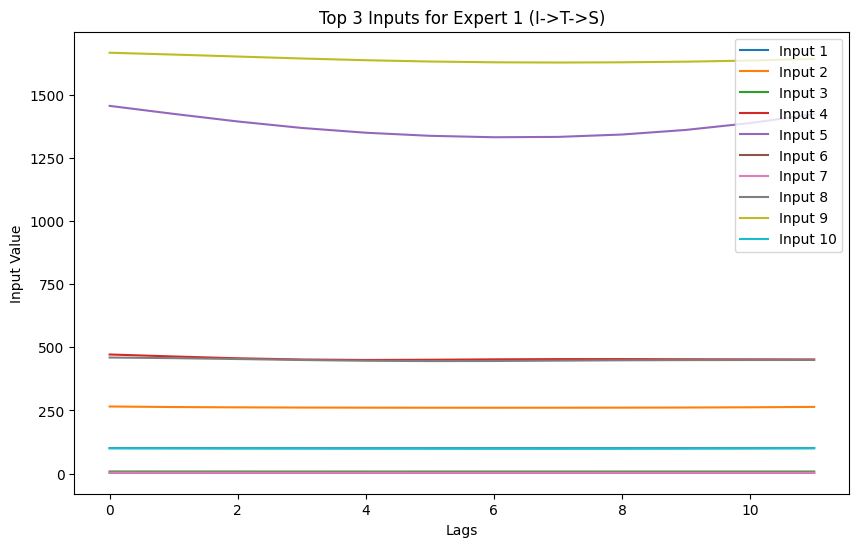

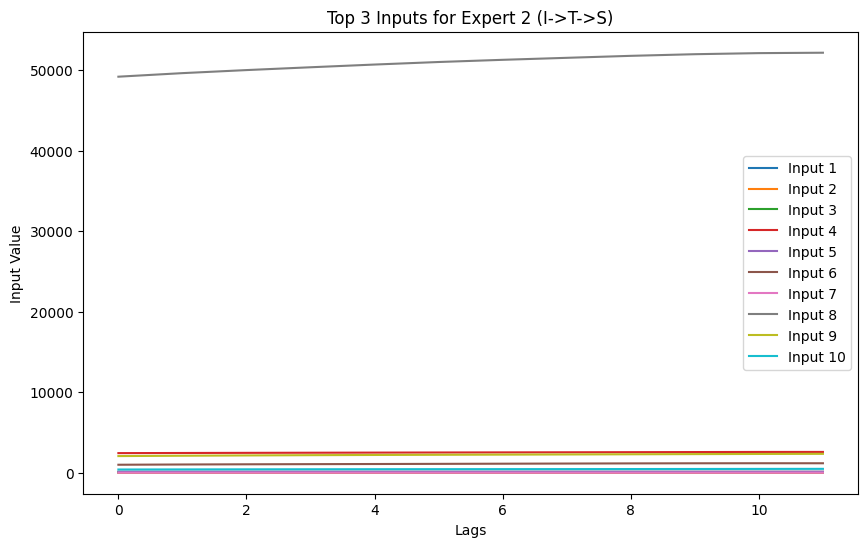

Resetting gate values for next epoch.
Predicting DataLoader 0: 100%|██████████| 20/20 [00:01<00:00, 19.90it/s] 
sMAPE for trend train: 0.06289089101999533
sMAPE for trend test: 0.18250373814970833


In [ ]:
# test on the trend component
y_train_t, y_test_t = train_test_split(Y_train_trend, horizon)

pred_train_trend = nf.predict(df=y_train_t, futr_df=y_test_t)
pred_test_trend = nf.predict(df= Y_train_trend, futr_df=Y_test_trend)

smape_train_trend = calculate_smape(y_test_t, pred_train_trend, 'NBeatsStackMoe')
smape_test_trend = calculate_smape(Y_test_trend, pred_test_trend, 'NBeatsStackMoe')
print(f'sMAPE for trend train: {smape_train_trend}')
print(f'sMAPE for trend test: {smape_test_trend}')

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 20/20 [00:00<00:00, 139.79it/s]
all_gates_cat shape: torch.Size([617, 3])

mean inputs_cat:  tensor([0.3951, 0.3117, 0.2931], device='cuda:0')

num_experts: tensor([166,  49,  16], device='cuda:0')

Best expert counts: tensor([317, 188, 112], device='cuda:0')


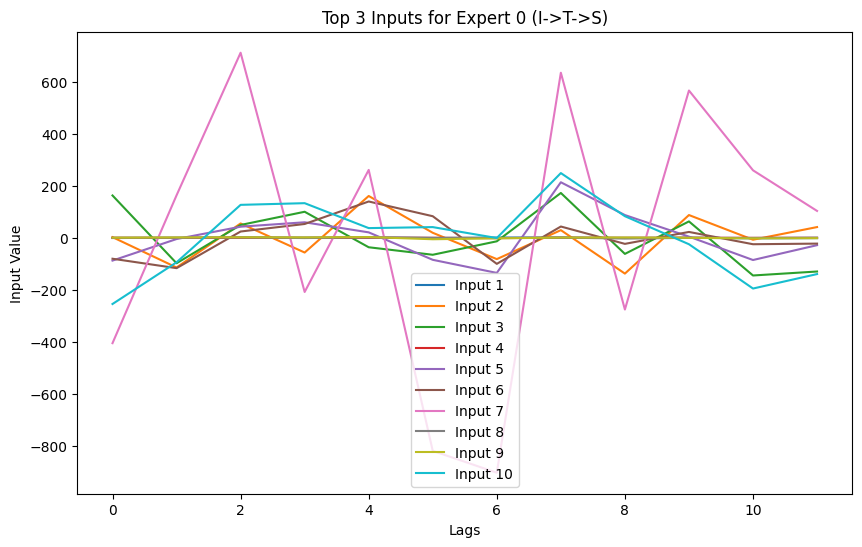

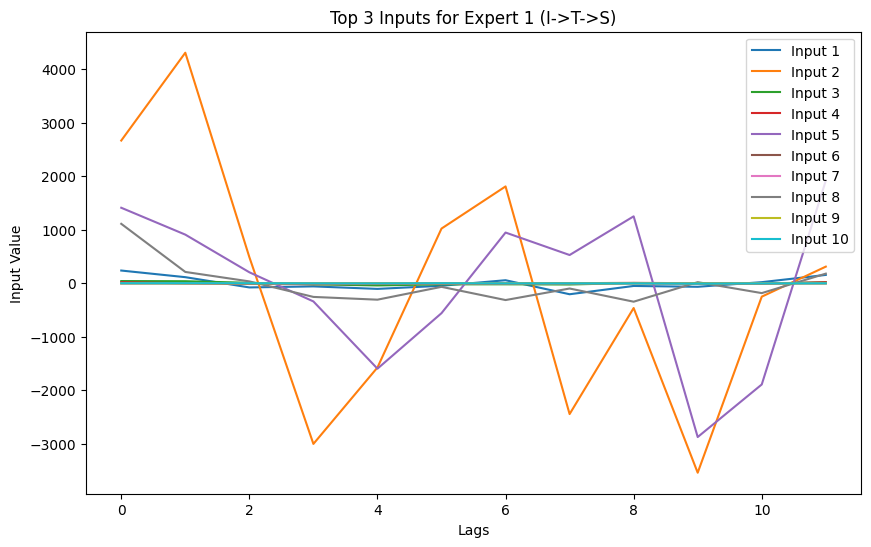

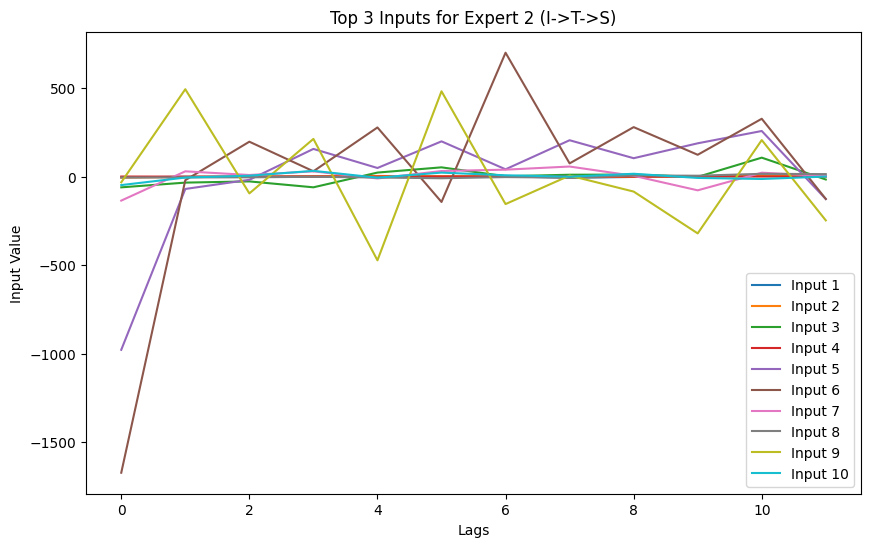

Resetting gate values for next epoch.
Predicting DataLoader 0: 100%|██████████| 20/20 [00:00<00:00, 27.87it/s] 

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 20/20 [00:00<00:00, 150.14it/s]
all_gates_cat shape: torch.Size([617, 3])

mean inputs_cat:  tensor([0.4029, 0.2957, 0.3014], device='cuda:0')

num_experts: tensor([180,  65,  25], device='cuda:0')

Best expert counts: tensor([320, 172, 125], device='cuda:0')


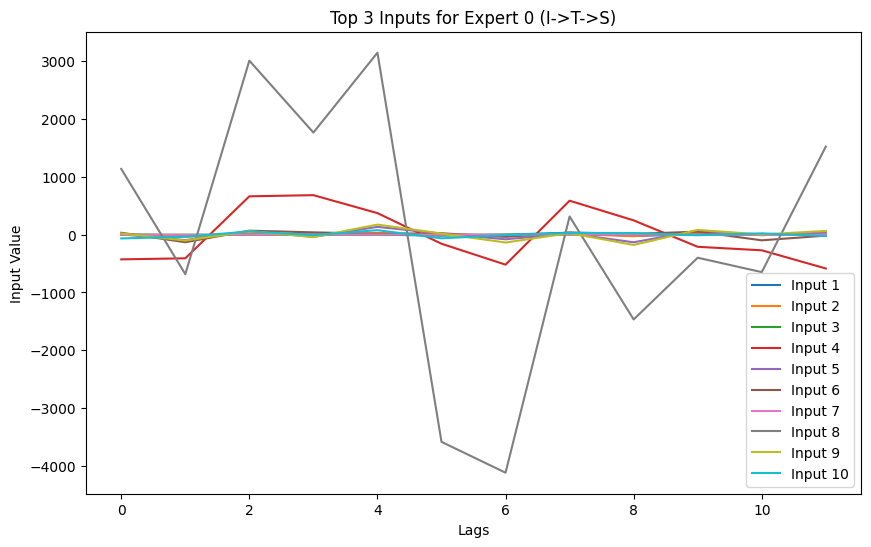

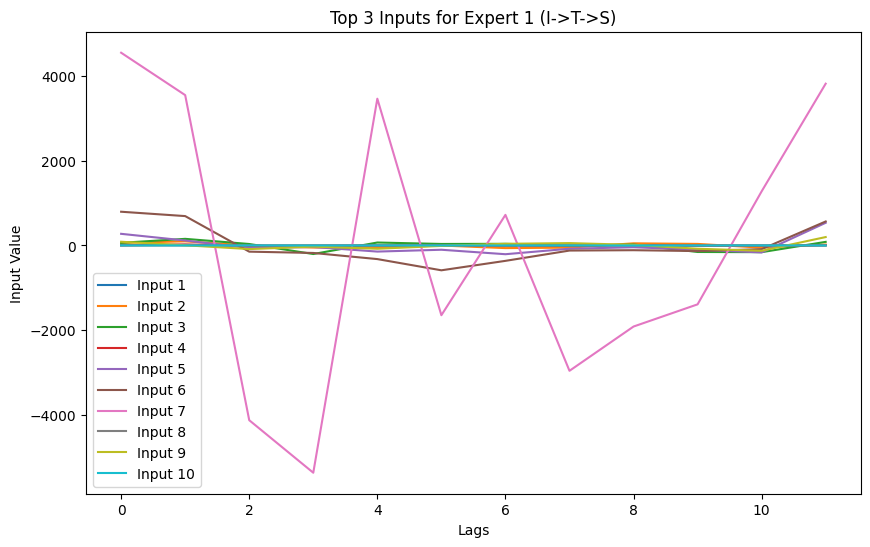

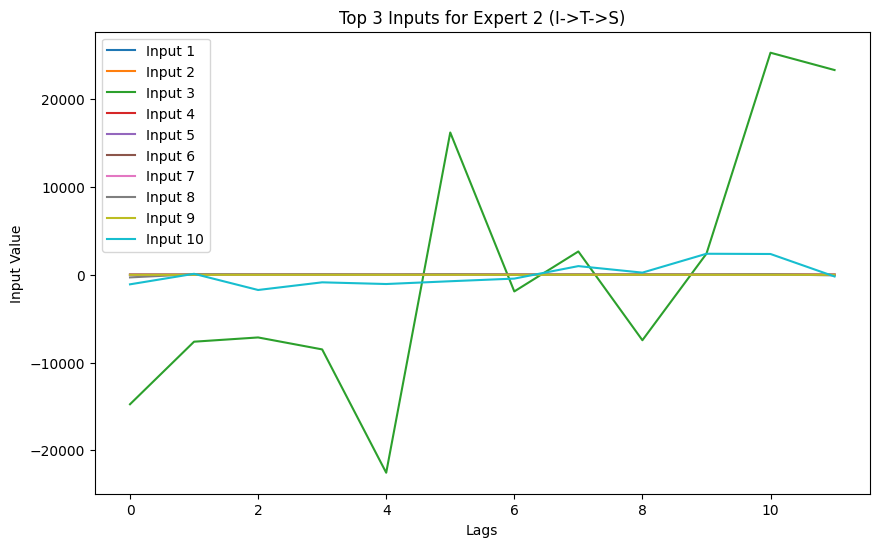

Resetting gate values for next epoch.
Predicting DataLoader 0: 100%|██████████| 20/20 [00:00<00:00, 28.26it/s] 
sMAPE for seasonal train: 1.0558372317989788
sMAPE for seasonal test: 1.1016988957153586


In [16]:
# test on the seasonal component
y_train_s, y_test_s = train_test_split(Y_train_seasonal, horizon)


pred_train_seasonal = nf.predict(df=y_train_s, futr_df=y_test_s)
pred_test_seasonal = nf.predict(df=Y_train_seasonal, futr_df=Y_test_seasonal)

smape_train_seasonal = calculate_smape(y_test_s, pred_train_seasonal, 'NBeatsStackMoe')
smape_test_seasonal = calculate_smape(Y_test_seasonal, pred_test_seasonal, 'NBeatsStackMoe')
print(f'sMAPE for seasonal train: {smape_train_seasonal}')
print(f'sMAPE for seasonal test: {smape_test_seasonal}')

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 20/20 [00:00<00:00, 140.49it/s]
all_gates_cat shape: torch.Size([617, 3])

mean inputs_cat:  tensor([0.3786, 0.3041, 0.3173], device='cuda:0')

num_experts: tensor([139,  51,  58], device='cuda:0')

Best expert counts: tensor([268, 172, 177], device='cuda:0')


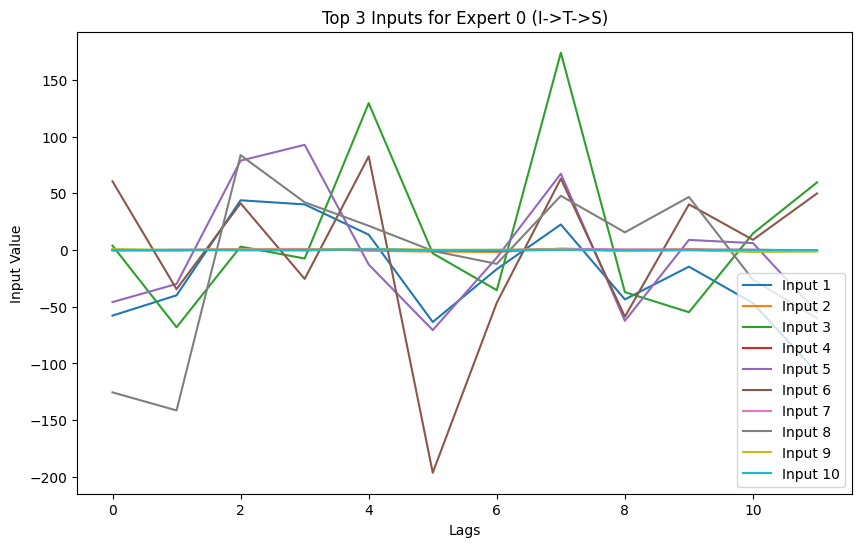

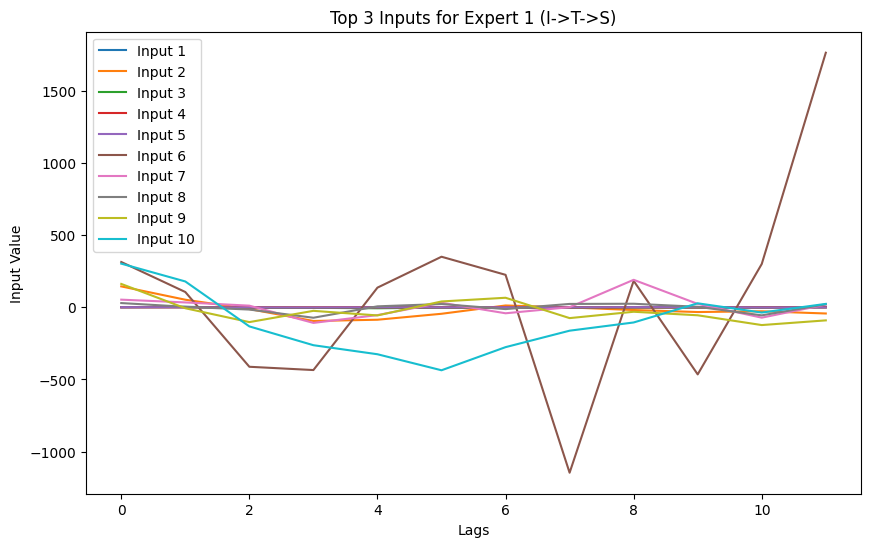

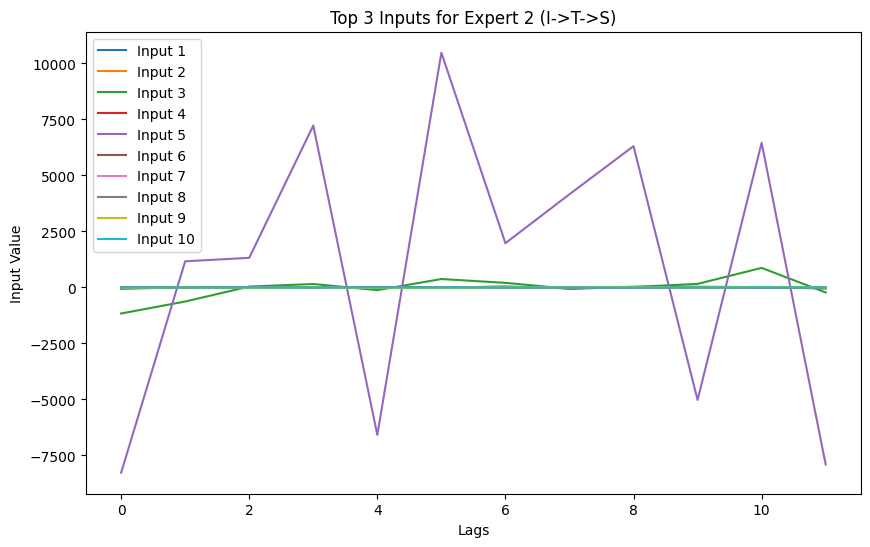

Resetting gate values for next epoch.
Predicting DataLoader 0: 100%|██████████| 20/20 [00:00<00:00, 24.95it/s] 

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 20/20 [00:00<00:00, 132.28it/s]
all_gates_cat shape: torch.Size([617, 3])

mean inputs_cat:  tensor([0.3874, 0.2813, 0.3313], device='cuda:0')

num_experts: tensor([157,  43,  64], device='cuda:0')

Best expert counts: tensor([284, 142, 191], device='cuda:0')


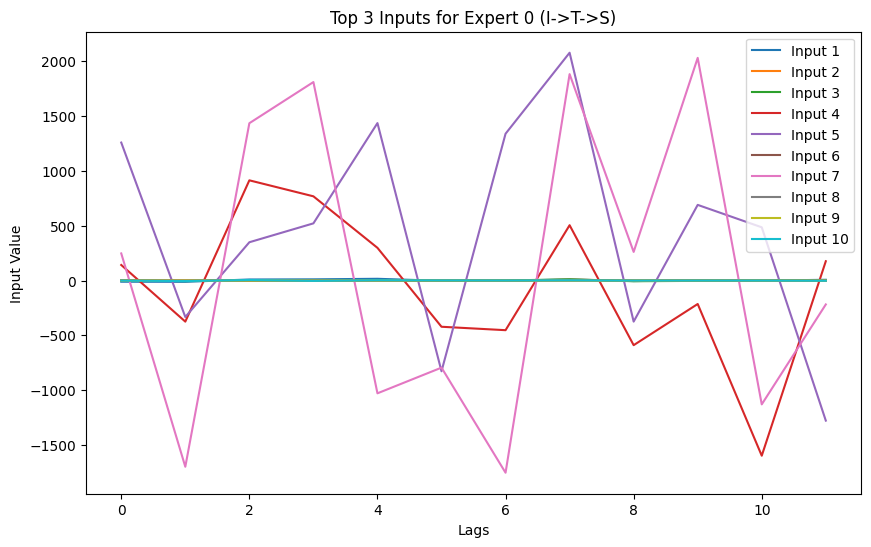

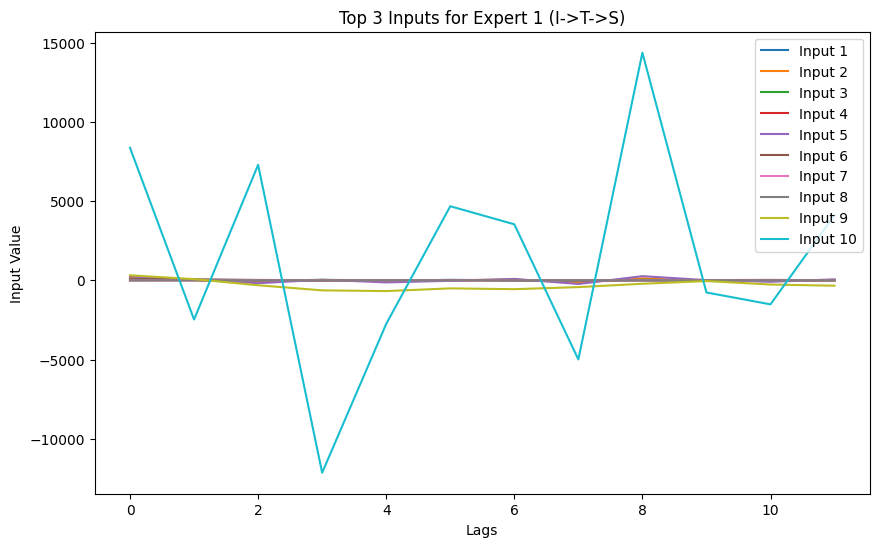

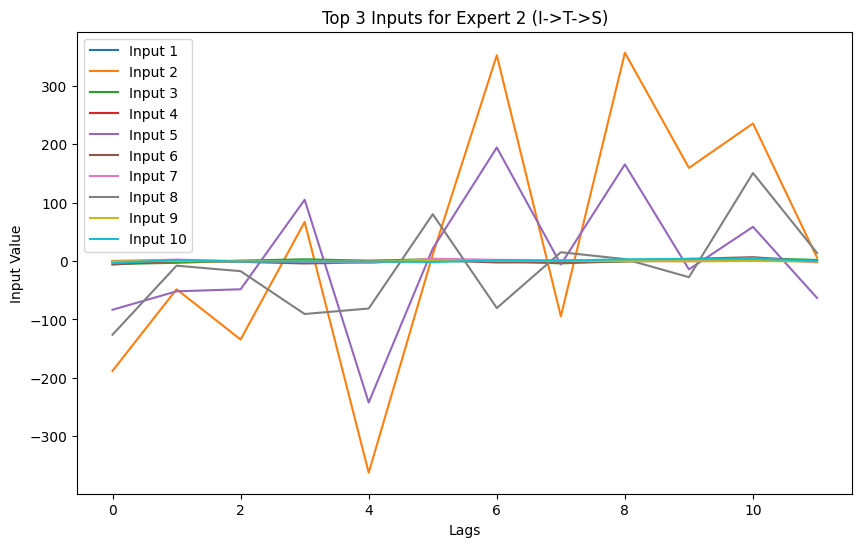

Resetting gate values for next epoch.
Predicting DataLoader 0: 100%|██████████| 20/20 [00:00<00:00, 24.85it/s] 
sMAPE for remainder train: 1.499629428885552
sMAPE for remainder test: 1.4806917941340851


In [17]:
# Test on the remainder component
y_train_r, y_test_r = train_test_split(Y_train_remainder, horizon)

pred_train_remainder = nf.predict(df=y_train_r, futr_df=y_test_r)
pred_test_remainder = nf.predict(df=Y_train_remainder, futr_df=Y_test_remainder)

smape_train_remainder = calculate_smape(y_test_r, pred_train_remainder, 'NBeatsStackMoe')
smape_test_remainder = calculate_smape(Y_test_remainder, pred_test_remainder, 'NBeatsStackMoe')
print(f'sMAPE for remainder train: {smape_train_remainder}')
print(f'sMAPE for remainder test: {smape_test_remainder}')

Now working with synthetic data

In [18]:
import numpy as np
# Parameters
n_series = 200         # Number of unique time series
length = input_size * 5 + horizon         # Length of each series
noise_std = 0.1       # Noise level

# Container for all series
dfs = []

for i in range(n_series):
    amplitude = np.random.uniform(8, 10)  # Random amplitude for variation
    freq = 1 / np.random.randint(20, 140)  # Random frequency for variation
    phase = np.random.rand() * 2 * np.pi  # Random phase shift
    x = np.arange(length)
    y = amplitude * np.sin(2 * np.pi * freq * x + phase) + np.random.normal(0, noise_std, length)
    
    df_i = pd.DataFrame({
        'unique_id': f'series_{i}',
        'ds': x,
        'y': y
    })
    dfs.append(df_i)

# Combine into one DataFrame
df_synte = pd.concat(dfs).reset_index(drop=True)

df_synte


,unique_id,ds,y
0,series_0,0,-7.757664
1,series_0,1,-7.878617
2,series_0,2,-8.145935
3,series_0,3,-8.281296
4,series_0,4,-8.391502
...,...,...,...
13595,series_199,63,-1.980384
13596,series_199,64,-1.375593
13597,series_199,65,-0.693976
13598,series_199,66,-0.381474


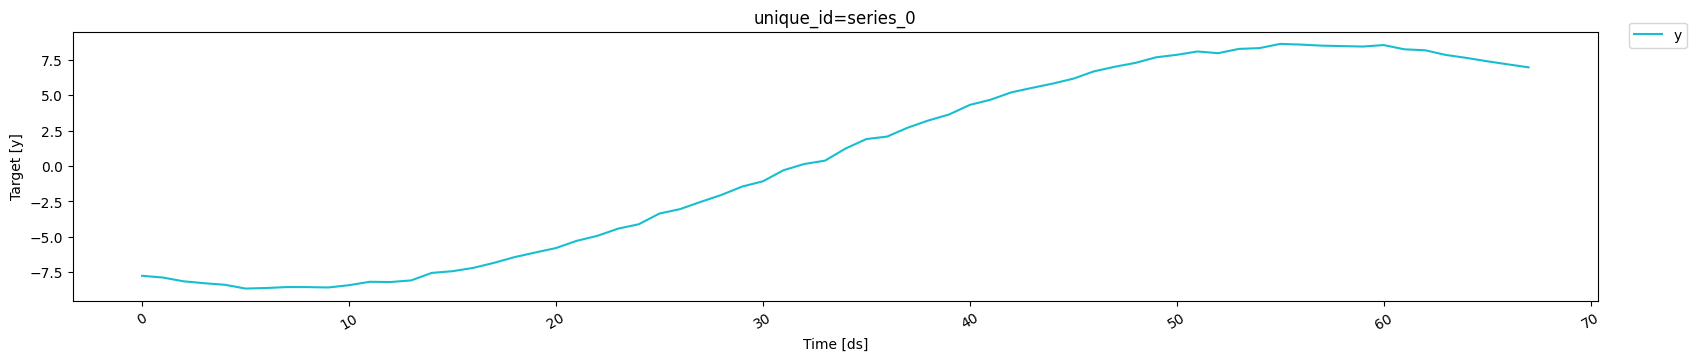

In [19]:
plot_series(df_synte, ids=['series_0'])

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 126.70it/s]
all_gates_cat shape: torch.Size([200, 3])

mean inputs_cat:  tensor([0.3727, 0.2799, 0.3474], device='cuda:0')

num_experts: tensor([27,  7, 81], device='cuda:0')

Best expert counts: tensor([ 80,  18, 102], device='cuda:0')


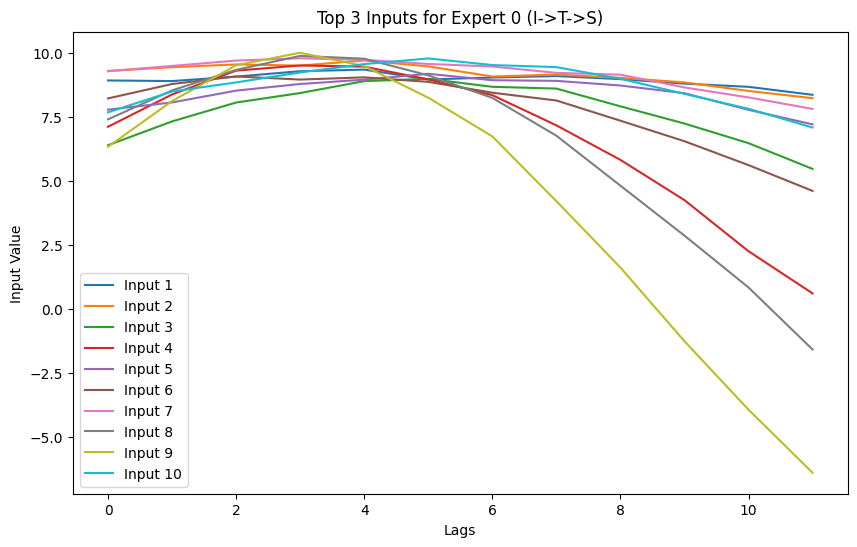

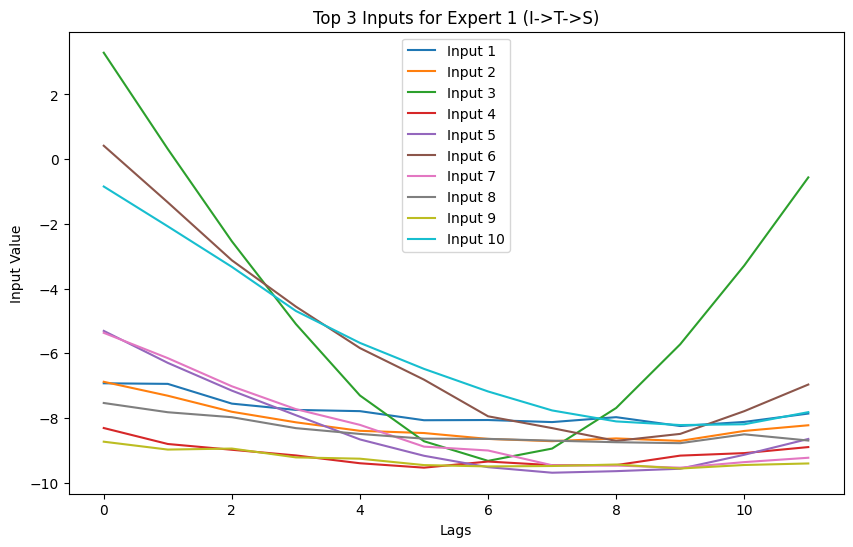

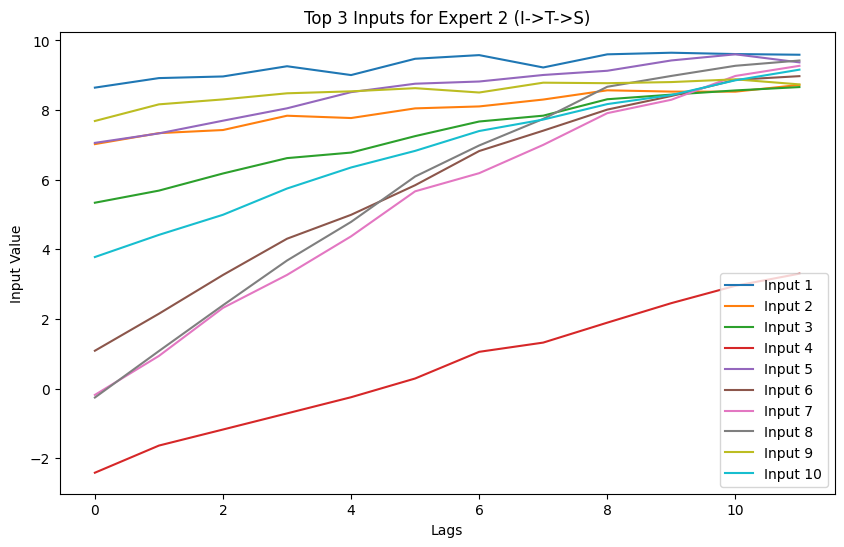

Resetting gate values for next epoch.
Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 10.41it/s] 
sMAPE for season synt test: 0.9320273397659254


In [20]:
# Test on the remainder component
y_train_s_syn, y_test_s_syn = train_test_split(df_synte, horizon)

pred_train_s_syn = nf.predict(df=y_train_s_syn, futr_df=y_test_s_syn)

smape_test_s_syn = calculate_smape(y_test_s_syn, pred_train_s_syn, 'NBeatsStackMoe')
print(f'sMAPE for season synt test: {smape_test_s_syn}')

...now for trend...

In [21]:
import numpy as np
import pandas as pd

# Parameters
n_series = 200         # Number of unique time series
length = input_size * 5 + horizon         # Length of each series

# Collect all series
dfs = []

for i in range(n_series):
    noise_std = np.random.uniform(100.0, 200.0)       # Increased noise level
    x = np.arange(length)
    
    # Random linear or polynomial trend with larger changes
    slope = np.random.uniform(1, 200.0)   # Steeper slopes
    intercept = np.random.uniform(0, 5000)
    poly_degree = np.random.choice([1, 2])  # Linear or quadratic
    
    if poly_degree == 1:
        y = slope * x + intercept
    else:
        a = np.random.uniform(-0.01, 0.01)  # Larger quadratic coefficient
        y = a * x**2 + slope * x + intercept
    
    # Add noise
    y += np.random.normal(0, noise_std, length)
    
    # Assemble into DataFrame
    df_i = pd.DataFrame({
        'unique_id': f'series_{i}',
        'ds': x,
        'y': y
    })
    dfs.append(df_i)

# Combine all
df_synte_t = pd.concat(dfs).reset_index(drop=True)

df_synte_t


,unique_id,ds,y
0,series_0,0,2745.951210
1,series_0,1,2647.797948
2,series_0,2,2888.645090
3,series_0,3,2916.280618
4,series_0,4,2920.137623
...,...,...,...
13595,series_199,63,3742.238741
13596,series_199,64,3554.609366
13597,series_199,65,3593.682911
13598,series_199,66,3581.090320


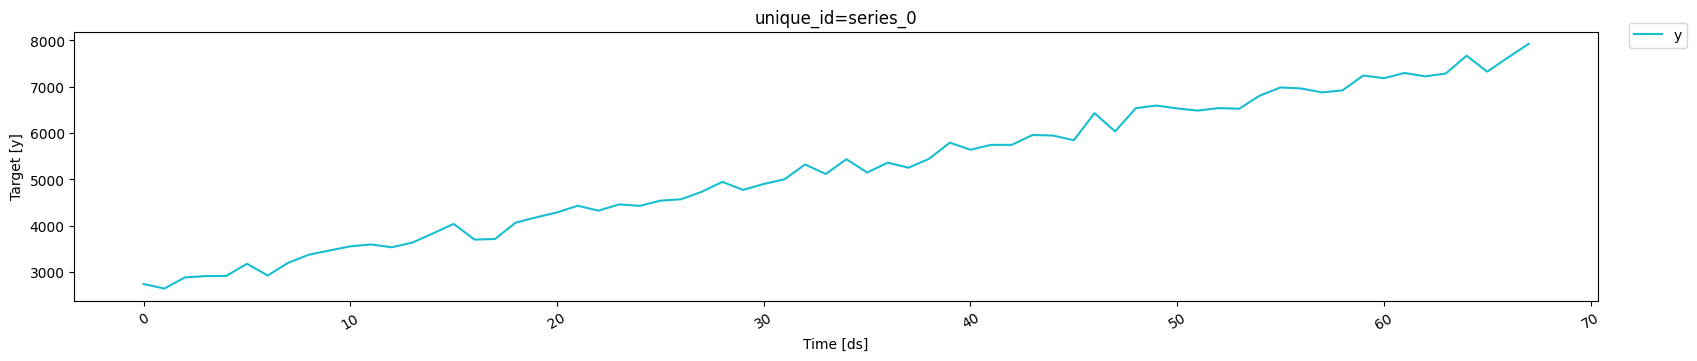

In [22]:
plot_series(df_synte_t, ids=['series_0'])

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 139.65it/s]
all_gates_cat shape: torch.Size([200, 3])

mean inputs_cat:  tensor([0.2993, 0.2103, 0.4904], device='cuda:0')

num_experts: tensor([  4,   0, 100], device='cuda:0')

Best expert counts: tensor([ 17,   4, 179], device='cuda:0')


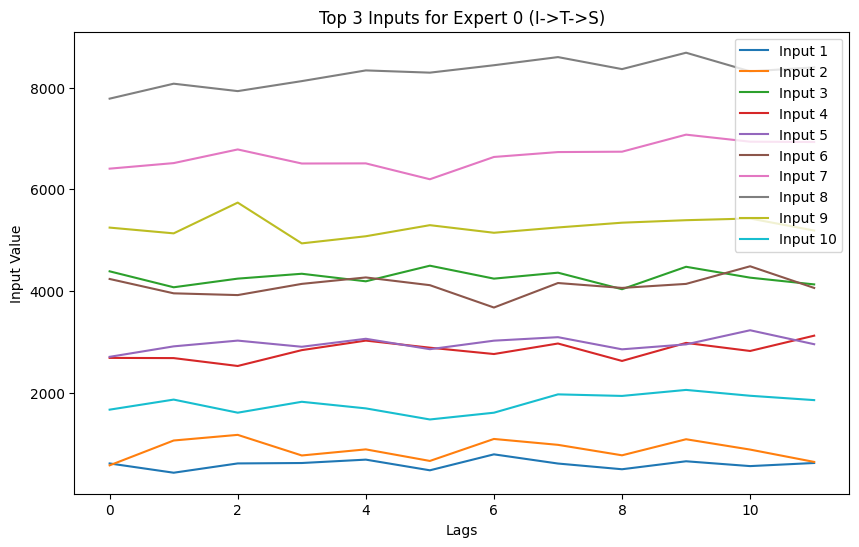

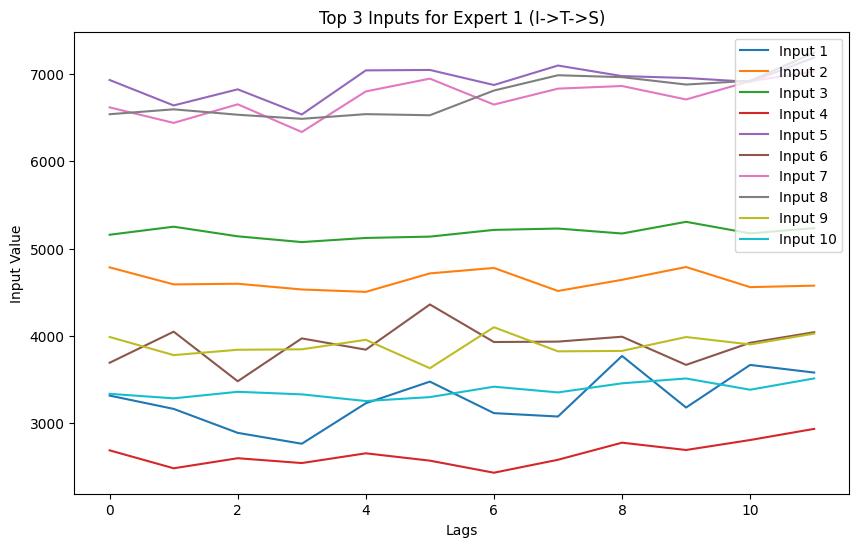

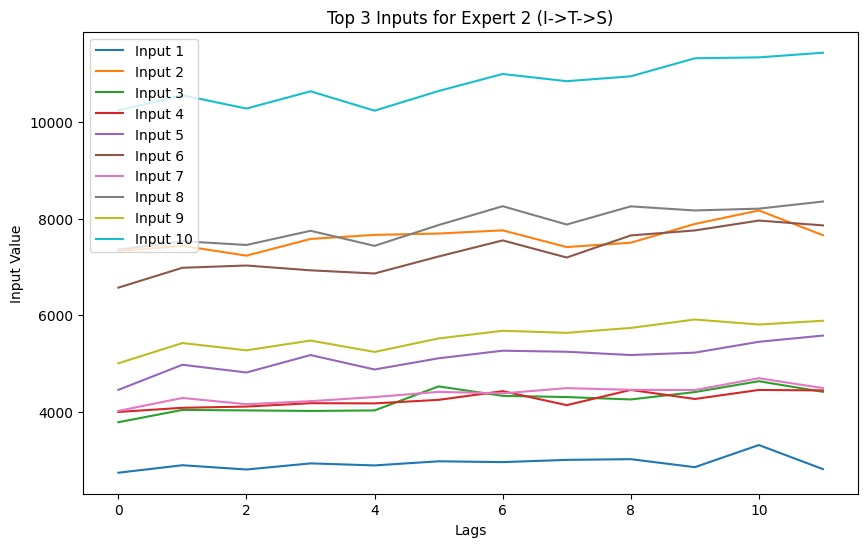

Resetting gate values for next epoch.
Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 10.64it/s] 
sMAPE for trend synt test: 0.030221333959938403


In [23]:
# Test on the remainder component
y_train_t_syn, y_test_t_syn = train_test_split(df_synte_t, horizon)

pred_train_t_syn = nf.predict(df=y_train_t_syn, futr_df=y_test_t_syn)

smape_test_t_syn = calculate_smape(y_test_t_syn, pred_train_t_syn, 'NBeatsStackMoe')
print(f'sMAPE for trend synt test: {smape_test_t_syn}')